## **Catégorisez automatiquement des questions**

### partie 4/8 (suite): Prédiction de tags, approche supervisée, sentence embedding

#### <br> L'objectif de ce notebook est de découvrir des techniques NLP plus avancées: Word2Vec (peut être remplacé par Doc2Vec), BERT, USE

<br>


## 1 Imports


### 1.1 Librairies


In [39]:
#
import os
import ast

import gdown
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import tensorflow as tf

from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers


### Fonctions


In [40]:
def turn_str_back_into_list(df):
    """Correct the type change due to .csv export"""

    df['title_nltk'] = df['title_nltk'].apply(ast.literal_eval)
    df['body_nltk'] = df['body_nltk'].apply(ast.literal_eval)
    df['title_spacy'] = df['title_spacy'].apply(ast.literal_eval)
    df['body_spacy'] = df['body_spacy'].apply(ast.literal_eval)
    df['all_tags'] = df['all_tags'].apply(ast.literal_eval)


df_freq = pd.DataFrame()

def keep_most_frequent_tags(list_tags, df_freq=df_freq, lim=100):
    """
    Keep only the n most frequent tags (default 100).

    Parameters:
    - liste_tokens (list): The input list of tokens to be processed.
    - forbidden_list (set): A set of forbidden tokens, which includes stop words,
      tokens exceeding upper frequency limits, and tokens falling below lower frequency limits.

    Returns:
    list: A filtered list of tokens that excludes stop words, tokens exceeding upper frequency limits,
    and tokens falling below lower frequency limits.
    """

    mandatory_list = df_freq['Tag'][:lim].tolist()
    filtered_list = [token for token in list_tags if token in mandatory_list]

    return filtered_list


def create_top_n_tags_feature(data, n=100, slice=1, df_freq=df_freq):
    data[f'top_tags_{n}'] = data['all_tags'].apply(
        lambda x: keep_most_frequent_tags(x, df_freq=df_freq, lim=n)
    )

    data = data.loc[data[f'top_tags_{n}'].apply(len) >= 0, :].copy()
    print(data.shape, '\n')

    slice_df = data[::slice]
    # slice_df.reset_index(drop=True, inplace=True)

    # stratify ?
    train_df, test_df = train_test_split(slice_df, test_size=0.1, random_state=42)

    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)


    return train_df, test_df



### Data


In [41]:
raw_data = pd.read_csv('./../0_data/cleaned_data/bow_classic.csv', sep=',')

turn_str_back_into_list(raw_data)

display(raw_data.tail())

print(raw_data.shape)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
47660,2011-05-23 22:22:56,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,"[c#, winforms, pdf, .net-4.0, printing]","[send, file, document, printer, print]","[send, file, document, printer, print, premise...","[send, file, document, printer, print]","[premise, user, click, file, spit, desktop, wa..."
47661,2011-05-23 21:15:51,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...","[visual-studio, visual-studio-2010, dll, style...","[mark, dll, error, message, vs2010]","[mark, dll, error, message, vs2010, run, get, ...","[error, message]","[run, error, message, need, mark, dll, set, dl..."
47662,2011-05-23 21:05:59,How to change a text file's name in C++?,"I would like to change a txt file's name, but ...","[c++, algorithm, file, directory, file-rename]","[change, text, file, name, c]","[change, text, file, name, c, like, change, tx...","[change, text, file]","[like, change, txt, file, find, example, want,..."
47663,2011-05-23 20:06:35,php implode (101) with quotes,Imploding a simple array \nwould look like th...,"[php, arrays, string, csv, implode]","[php, quote]","[php, quote, array, look, array, array, lastna...",[quote],"[implode, array, look, array, email, phone, ar..."
47664,2011-05-23 20:00:57,What characters are allowed in a iOS file name?,I'm looking for a way to make sure a string ca...,"[ios, file, filenames, character-encoding, nsf...","[character, allow, file, name]","[character, allow, file, name, look, way, make...","[character, allow, file]","[look, way, string, file, section, code, delet..."


(47665, 8)


In [43]:
all_tags = [tag for tags in raw_data['all_tags'] for tag in tags]
print(f'Il y a {len(all_tags)} tags au total. \n')
print(f'Il y a {len(set(all_tags))} tags différents. \n')

# display(questions_tags)

# Fréquence
tag_frequencies_dict = {}
for tag in all_tags:
    tag_frequencies_dict[tag] = tag_frequencies_dict.get(tag, 0) + 1

# Sort the dictionary items by values in descending order
sorted_tag_frequencies = dict(sorted(tag_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Extract tags and frequencies
tags = list(sorted_tag_frequencies.keys())
frequencies = list(sorted_tag_frequencies.values())

df_freq = pd.DataFrame({'Tag': tags, 'Frequency': frequencies})


train_df, test_df = create_top_n_tags_feature(data=raw_data, n=50, slice=10, df_freq=df_freq)


Il y a 238327 tags au total. 

Il y a 15817 tags différents. 

(47665, 9) 



## 2 Static embedding : word vectors


### 2.1 Using Pretrained, Third-Party Vectors


In [68]:
# Destination path where the file will be saved
output = "GoogleNews-vectors-negative300.bin.gz"

# Check if the file already exists
if not os.path.exists(output):
    # URL of the file in Google Drive
    url = "https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku"

    # Download the file from Google Drive
    gdown.download(url, quiet=False)
    print("File downloaded successfully.")
else:
    print("File already exists.")


File already exists.


In [45]:
word_vectors = KeyedVectors.load_word2vec_format(output, binary=True, limit=200000)


### 2.2 What a word vector looks like


In [46]:
pizza = word_vectors['pizza']
print(f'Vector dimension: {pizza.shape}')

# The embedding for the word 'pizza'.
print(pizza)


Vector dimension: (300,)
[-1.25976562e-01  2.53906250e-02  1.66992188e-01  5.50781250e-01
 -7.66601562e-02  1.28906250e-01  1.02539062e-01 -3.94821167e-04
  1.21582031e-01  4.32128906e-02  1.72851562e-01 -6.83593750e-02
  3.41796875e-01  8.39843750e-02  6.68945312e-02  2.67578125e-01
 -3.71093750e-02 -5.56640625e-02  1.80664062e-01  1.90429688e-02
 -5.07812500e-02  9.03320312e-03  1.76757812e-01  6.49414062e-02
 -6.25000000e-02 -9.42382812e-02 -9.71679688e-02  4.00390625e-01
  1.15234375e-01  1.02539062e-01 -1.86767578e-02 -2.69531250e-01
  1.80664062e-01  1.25000000e-01 -3.17382812e-02 -5.49316406e-02
  3.45703125e-01 -1.57470703e-02  1.82390213e-05  2.07031250e-01
 -1.25976562e-01 -2.83203125e-01  2.00195312e-01  8.34960938e-02
 -4.73632812e-02 -3.11279297e-02 -2.61718750e-01  1.69921875e-01
 -2.02636719e-02  1.53320312e-01 -1.20605469e-01  3.75000000e-01
 -5.68847656e-02 -4.76074219e-03 -1.95312500e-01 -2.03125000e-01
  3.00781250e-01 -1.01074219e-01 -3.18359375e-01 -9.03320312e-02


### 2.3 compare two words


In [47]:
# Appétissant !

print(word_vectors.similarity('pizza', 'tomato'))
print(word_vectors.similarity('pizza', 'sauce'))
print(word_vectors.similarity('pizza', 'cheese'))

# Knew it ! Cheese is the most important. It's scientifically proven.


0.35505623
0.3695989
0.4708358


In [48]:
print(word_vectors.similarity('pizza', 'gorilla'))
print(word_vectors.similarity('pizza', 'tree'))
print(word_vectors.similarity('pizza', 'yoga'))

# So pizza has more to do with trees than gorillas ?


0.108518735
0.11185603
0.14119942


In [71]:
# On our data

print(word_vectors.similarity('html', 'javascript'))
print(word_vectors.similarity('python', 'javascript'))
print(word_vectors.similarity('java', 'javascript')) # bien vu !
print(word_vectors.similarity('html', 'css'))


0.549539
0.12199123
0.549539
0.33437246
0.5491108


### 2.4 OOV


In [50]:
try:
  word_vectors['womblyboo']
except KeyError as e:
  print(e)

#


"Key 'womblyboo' not present"


### 2.5 Compare two sentences


In [51]:
word_vectors.n_similarity("dog bites man".split(), "canine nips human".split())


0.5314661

In [52]:
word_vectors.n_similarity("martian dolphins are hostile".split(), "i flunked calligraphy school".split())


0.14505778

In [53]:
word_vectors.n_similarity("dog bites man".split(), "man bites dog".split())
# Same


1.0

In [54]:
s1 = "Volkswagen intends to double electric car sales in China".lower().split()
s2 = "First Toyota with solid state battery will be hybrid".lower().split()
word_vectors.n_similarity(s1, s2)


0.52682734

In [55]:
# Test on our data

s1 = test_df['title'][0]
print(s1)
s2 = test_df['title'][1]
print(s2)

word_vectors.n_similarity(s1, s2)


Laravel chmod(/var/dev/project/storage/oauth-public.key): Operation failed: Operation not permitted
Python/Selenium incognito/private mode


0.9873358

### 2.6 most_similar, doesnt_match


In [56]:
word_vectors.most_similar(positive=['cell'], topn=10)


[('cells', 0.8180485963821411),
 ('Cells', 0.6146953105926514),
 ('Cell', 0.532131552696228),
 ('cellular', 0.5272858738899231),
 ('tumor_cells', 0.5097642540931702),
 ('ES_cells', 0.4866572618484497),
 ('immune_cells', 0.48319193720817566),
 ('epithelial_cells', 0.4781806468963623),
 ('molecule', 0.47757473587989807),
 ('proteins', 0.47494736313819885)]

In [57]:
word_vectors.most_similar(positive=['cell', 'phone'], topn=10)


[('cell_phone', 0.6861390471458435),
 ('cellular', 0.6757438778877258),
 ('cellphone', 0.6633196473121643),
 ('telephone', 0.6474040150642395),
 ('Phone', 0.6051893830299377),
 ('phones', 0.5896332859992981),
 ('cells', 0.5850948095321655),
 ('cordless_phone', 0.5711769461631775),
 ('Cell', 0.561764121055603),
 ('landline', 0.546729564666748)]

In [58]:
# doublt we'll use this one, but funny :

word_vectors.doesnt_match(["apple", "orange", "hamburger", "banana", "kiwi"])


'hamburger'

In [59]:
word_vectors.doesnt_match(["Microsoft", "Apple", "Toyota", "Amazon", "Netflix", "Google"])


'Toyota'

### 2.7 Visualisons


In [60]:
def display_pca_scatterplot(model, words):
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r', s=128)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

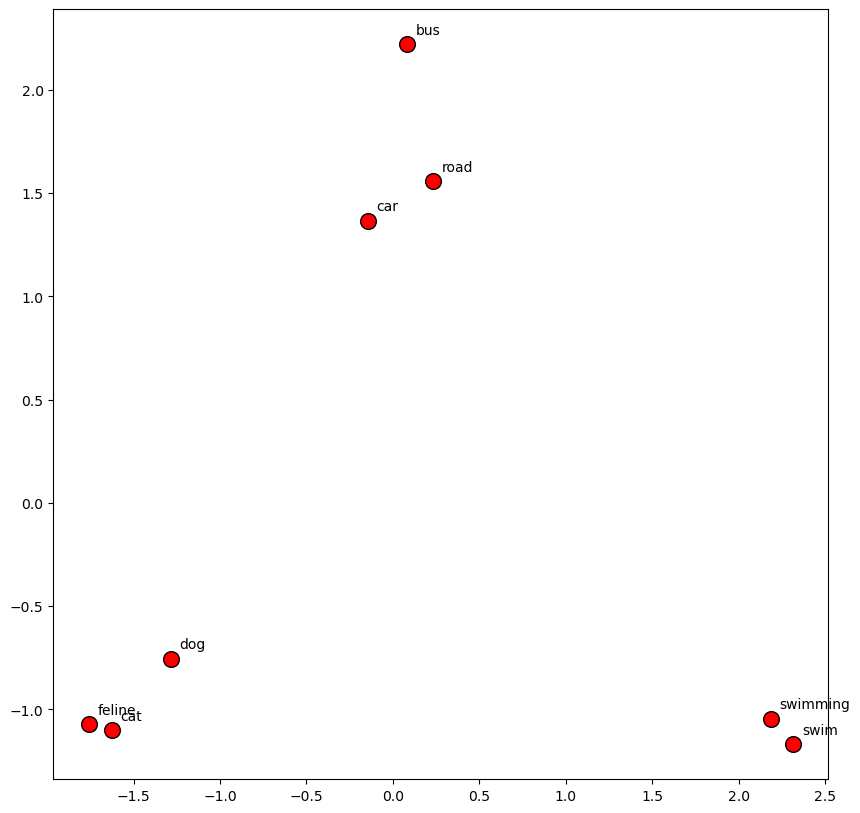

In [61]:
display_pca_scatterplot(word_vectors, ['swim', 'swimming', 'cat', 'dog', 'feline', 'road', 'car', 'bus'])


In [62]:
word_vectors.most_similar(positive=['Italy', 'London'], negative=['Rome'], topn=3)


[('UK', 0.623056948184967),
 ('Britain', 0.6016389727592468),
 ('United_Kingdom', 0.5343458652496338)]

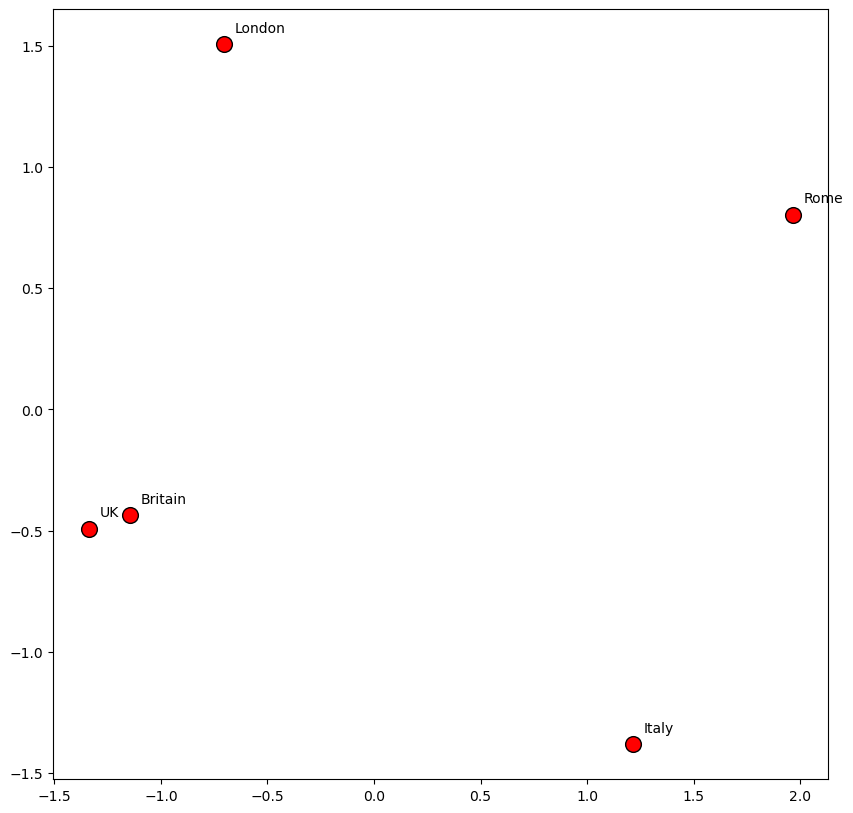

In [63]:
display_pca_scatterplot(word_vectors, ['Rome', 'Italy', 'London', 'Britain', 'UK'])

## 3 Using Pretrained Word Vectors for Classification


In [64]:
word_vectors = KeyedVectors.load_word2vec_format(output, binary=True, limit=1000000)


In [65]:
#

## Ressources


In [66]:
# Word
# https://colab.research.google.com/github/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_word_vectors.ipynb#scrollTo=SBQlbyiVY3WJ